# From: BERT Fine-Tuning Tutorial with PyTorch
By Chris McCormick and Nick Ryan

*Revised on March 20, 2020 - Switched to `tokenizer.encode_plus` and added validation loss. See [Revision History](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX#scrollTo=IKzLS9ohzGVu) at the end for details.*




In this tutorial I'll show you how to use BERT with the huggingface PyTorch library to quickly and efficiently fine-tune a model to get near state of the art performance in sentence classification. More broadly, I describe the practical application of transfer learning in NLP to create high performance models with minimal effort on a range of NLP tasks.

This post is presented in two forms--as a blog post [here](http://mccormickml.com/2019/07/22/BERT-fine-tuning/) and as a Colab Notebook [here](https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX). 

The content is identical in both, but: 
* The blog post includes a comments section for discussion. 
* The Colab Notebook will allow you to run the code and inspect it as you read through.

I've also published a video walkthrough of this post on my YouTube channel! [Part 1](https://youtu.be/x66kkDnbzi4) and [Part 2](https://youtu.be/Hnvb9b7a_Ps).



# 1. Setup

## 1.1. Using Colab GPU for Training


In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [3]:
!nvidia-smi

Sun Apr 11 10:38:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.67       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    50W / 300W |    429MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 1.2. Installing the Hugging Face Library


In [4]:
!pip install transformers

In [5]:
import logging
import transformers
logging.getLogger("transformers").setLevel(logging.ERROR)  # No warning on sample size

# 2. Loading Sentiment Dataset


## 2.1. Copy Data

In [6]:
# mount my Google Drive directory and access the training data located there
from google.colab import drive
gdrive_dir = '/content/gdrive/'
drive.mount(gdrive_dir, force_remount=True)

Mounted at /content/gdrive/


In [7]:
data_dir = "/content/gdrive/MyDrive/Colab_Notebooks/data"
train_file = 'sentiment-train.csv'
test_file = 'sentiment-test.csv'

In [8]:
# copy the data to the current Colab working directory
!cp $data_dir/$train_file .
!cp $data_dir/$test_file .

## 2.2. Parse

We can see from the file names that both `tokenized` and `raw` versions of the data are available. 

We can't use the pre-tokenized version because, in order to apply the pre-trained BERT, we *must* use the tokenizer provided by the model. This is because (1) the model has a specific, fixed vocabulary and (2) the BERT tokenizer has a particular way of handling out-of-vocabulary words.

We'll use pandas to parse the "in-domain" training set and look at a few of its properties and data points.

In [9]:
import pandas as pd

# Load the dataset into a pandas dataframe.
df = pd.read_csv(train_file, header=None, skiprows=1, names=['label', 'sentence'])

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 60,000



,label,sentence
50216,0,@ruby_may ahhhh that's whats gian was.. how wa...
39483,0,@HaileyATL her mom always finds something to s...
33777,0,@zenojones I can't go to sleep... Too much to ...
34809,0,tweetdeck seems to have died on me Need to fi...
53093,0,Looking through warranty for #eee PC. Battery...
874,1,@arataka yay! you found them!!!
461,1,i'm feeling somewhat artistic...time to break ...
47535,0,Forget about what I said about feeling better ...
31823,0,"Dad was admitted to hospital yesterday, so wan..."
13662,1,@kimloves and I like your hair. It's very big...


In [10]:
df.loc[df.label == 0].sample(5)[['sentence', 'label']]

,sentence,label
39697,@ifoundmycapo no. Real pls?,0
52861,"man, i feel really down today like, EVERYONE ...",0
31714,yo that was hella weird my twitter got deleted,0
52197,So tired...3 hours of work left and so much to...,0
43881,Wishing I was in Del Mar with Pam,0




Let's extract the sentences and labels of our training set as numpy ndarrays.

In [11]:
# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

In [12]:
sentences[:10]

array(['I LOVE @Health4UandPets u guys r the best!! ',
       'im meeting up with one of my besties tonight! Cant wait!!  - GIRL TALK!!',
       '@DaRealSunisaKim Thanks for the Twitter add, Sunisa! I got to meet you once at a HIN show here in the DC area and you were a sweetheart. ',
       'Being sick can be really cheap when it hurts too much to eat real food  Plus, your friends make you soup',
       '@LovesBrooklyn2 he has that effect on everyone ',
       '@ProductOfFear You can tell him that I just burst out laughing really loud because of that  Thanks for making me come out of my sulk!',
       '@r_keith_hill Thans for your response. Ihad already find this answer ',
       "@KeepinUpWKris I am so jealous, hope you had a great time in vegas! how did you like the ACM's?! LOVE YOUR SHOW!! ",
       '@tommcfly ah, congrats mr fletcher for finally joining twitter ',
       '@e4VoIP I RESPONDED  Stupid cat is helping me type. Forgive errors '],
      dtype=object)

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [13]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [14]:
# Print the original sentence.
print('Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

Original:  I LOVE @Health4UandPets u guys r the best!! 
Tokenized:  ['i', 'love', '@', 'health', '##4', '##uan', '##dp', '##ets', 'u', 'guys', 'r', 'the', 'best', '!', '!']
Token IDs:  [1045, 2293, 1030, 2740, 2549, 13860, 18927, 8454, 1057, 4364, 1054, 1996, 2190, 999, 999]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

*Side Note: The input format to BERT seems "over-specified" to me... We are required to give it a number of pieces of information which seem redundant, or like they could easily be inferred from the data without us explicity providing it. But it is what it is, and I suspect it will make more sense once I have a deeper understanding of the BERT internals.*

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [15]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)


Max sentence length:  111


Just in case there are some longer test sentences, I'll set the maximum length to 64.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [16]:
def encode_data(train_file, tokenizer):

    df = pd.read_csv(train_file, header=None, skiprows=1, names=['label', 'sentence'])
    # Get the lists of sentences and their labels.
    sentences = df.sentence.values
    labels = df.label.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                            truncation=True,
                    )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # Print sentence 0, now as a list of IDs.
    print('Original: ', sentences[0])
    print('Token IDs:', input_ids[0])
    return input_ids, attention_masks, labels

In [17]:
input_ids, attention_masks, labels =  encode_data(train_file, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I LOVE @Health4UandPets u guys r the best!! 
Token IDs: tensor([  101,  1045,  2293,  1030,  2740,  2549, 13860, 18927,  8454,  1057,
         4364,  1054,  1996,  2190,   999,   999,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [18]:
print(input_ids.shape)
print(attention_masks.shape)

torch.Size([60000, 64])
torch.Size([60000, 64])


## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [19]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

54,000 training samples
6,000 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [20]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [21]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model = model.cuda()

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [22]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [24]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [25]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [26]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

We're ready to kick off the training!

In [27]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [28]:
def train(model, epochs=epochs, log_interval=100):

    # We'll store a number of quantities such as training and validation loss, 
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()

    # For each epoch...
    for epoch_i in range(0, epochs):
        
        # ========================================
        #               Training
        # ========================================
        
        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to 
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the 
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because 
            # accumulating the gradients is "convenient while training RNNs". 
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()        

            # Perform a forward pass (evaluate the model on this training batch).
            # In PyTorch, calling `model` will in turn call the model's `forward` 
            # function and pass down the arguments. The `forward` function is 
            # documented here: 
            # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
            # The results are returned in a results object, documented here:
            # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
            # Specifically, we'll get the loss (because we provided labels) and the
            # "logits"--the model outputs prior to activation.
            result = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask, 
                        labels=b_labels,
                        return_dict=True)

            loss = result.loss
            logits = result.logits

            # Progress update every 40 batches.
            if step % log_interval == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                
                # Report progress.
                print('Step: {}/{}, Loss: {}, Elapsed: {}'.format(step, len(train_dataloader), loss.item(), elapsed))

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value 
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)            
        
        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        print("")
        print("Average training loss: {0:.2f}".format(avg_train_loss))
        print("Training epcoh took: {:}".format(training_time))
            
        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:
            
            # Unpack this training batch from our dataloader. 
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using 
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids 
            #   [1]: attention masks
            #   [2]: labels 
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            
            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():        

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which 
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

            # Get the loss and "logits" output by the model. The "logits" are the 
            # output values prior to applying an activation function like the 
            # softmax.
            loss = result.loss
            logits = result.logits
                
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)
            

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)
        
        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        
        print("Validation Loss: {0:.2f}".format(avg_val_loss))
        print("Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )
    
    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
    return training_stats

In [29]:
training_stats = train(model, log_interval=400)


======== Epoch 1 / 4 ========
Training...
Step: 400/1688, Loss: 0.3336910605430603, Elapsed: 0:00:50
Step: 800/1688, Loss: 0.5149307250976562, Elapsed: 0:01:41
Step: 1200/1688, Loss: 0.40278008580207825, Elapsed: 0:02:31
Step: 1600/1688, Loss: 0.39898040890693665, Elapsed: 0:03:22

Average training loss: 0.40
Training epcoh took: 0:03:33

Running Validation...
Accuracy: 0.85
Validation Loss: 0.35
Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
Step: 400/1688, Loss: 0.22848336398601532, Elapsed: 0:00:51
Step: 800/1688, Loss: 0.09327801316976547, Elapsed: 0:01:41
Step: 1200/1688, Loss: 0.2063073217868805, Elapsed: 0:02:32
Step: 1600/1688, Loss: 0.13054749369621277, Elapsed: 0:03:22

Average training loss: 0.28
Training epcoh took: 0:03:33

Running Validation...
Accuracy: 0.85
Validation Loss: 0.37
Validation took: 0:00:07

======== Epoch 3 / 4 ========
Training...
Step: 400/1688, Loss: 0.07747603207826614, Elapsed: 0:00:51
Step: 800/1688, Loss: 0.18490155041217804, E

Let's view the summary of the training process.

In [30]:
import pandas as pd

def view_stats(training_stats):
    # Display floats with two decimal places.
    pd.set_option('precision', 2)

    # Create a DataFrame from our training statistics.
    df_stats = pd.DataFrame(data=training_stats)

    # Use the 'epoch' as the row index.
    df_stats = df_stats.set_index('epoch')

    # A hack to force the column headers to wrap.
    #df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

    # Display the table.
    return df_stats

In [31]:
df_stats = view_stats(training_stats)
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.40,0.35,0.85,0:03:33,0:00:07
2,0.28,0.37,0.85,0:03:33,0:00:07
3,0.18,0.44,0.85,0:03:33,0:00:07
4,0.12,0.55,0.85,0:03:33,0:00:07


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

In [32]:
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

def show_status(df_stats):
    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12,6)

    # Plot the learning curve.
    plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
    plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

    # Label the plot.
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.xticks([1, 2, 3, 4])

    plt.show()

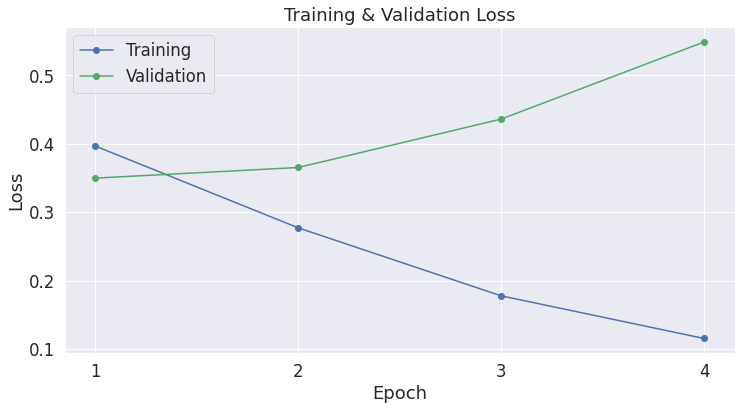

In [33]:
show_status(df_stats)

# 5. Performance On Test Set

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [34]:
import pandas as pd
batch_size = 32 

def load_test_data(test_file, batch_size=batch_size):
    # Load the dataset into a pandas dataframe.
    df = pd.read_csv(test_file, header=None, skiprows=1, names=['label', 'sentence'])

    # Report the number of sentences.
    print('Number of test sentences: {:,}\n'.format(df.shape[0]))

    # Create sentence and label lists
    sentences = df.sentence.values
    labels = df.label.values

    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 64,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            return_tensors = 'pt',     # Return pytorch tensors.
                    )
        
        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        
        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)

    # Create the DataLoader.
    prediction_data = TensorDataset(input_ids, attention_masks, labels)
    prediction_sampler = SequentialSampler(prediction_data)
    prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
    return prediction_dataloader

In [35]:
prediction_dataloader = load_test_data(test_file)

Number of test sentences: 359



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [36]:
from sklearn.metrics import accuracy_score

def evaluate_test(test_loader):
    # Prediction on test set
    print('Predicting labels for {:,} test sentences...'.format(len(test_loader)*batch_size))

    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    predictions , true_labels = [], []

    # Predict 
    for batch in prediction_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)

        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            result = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask,
                            return_dict=True)

        logits = result.logits

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        pred = np.argmax(logits, axis=1)
        predictions.extend(pred)
        true_labels.extend(label_ids)
    acc = accuracy_score(predictions, true_labels)
    print("Accuracy: {}%".format(np.round(acc*100,2)))

In [37]:
evaluate_test(prediction_dataloader)

Predicting labels for 384 test sentences...
Accuracy: 86.07%


# 6. Performance On Spanish-Sentiment Test Set

## 6.1 Data Preparation

In [38]:
spanish_test = 'spanish-sentiment-test.csv'

In [39]:
# copy the data to the current Colab working directory
!cp $data_dir/$spanish_test .

In [40]:
prediction_dataloader = load_test_data(spanish_test)

Number of test sentences: 359



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## 6.2. Evaluate on Test Set


In [41]:
evaluate_test(prediction_dataloader)

Predicting labels for 384 test sentences...
Accuracy: 58.77%


# 6. Multilingual Model (XLM-Roberta)

## 6.1 Prepare Data

In [42]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base', do_lower_case=True)

In [43]:
df = pd.read_csv(train_file, header=None, skiprows=1, names=['label', 'sentence'])

# Get the lists of sentences and their labels.
sentences = df.sentence.values
labels = df.label.values

In [44]:
input_ids, attention_masks, labels =  encode_data(train_file, tokenizer)

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I LOVE @Health4UandPets u guys r the best!! 
Token IDs: tensor([     0,     87, 129138,   1374, 177109,    617,   1062,   2940,    683,
          7831,     75,  51484,   1690,     70,   2965,   1146,      2,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1])


In [45]:
# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

54,000 training samples
6,000 validation samples


In [46]:
# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

## 6.2 Train Model

In [47]:
from transformers import XLMRobertaForSequenceClassification

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = XLMRobertaForSequenceClassification.from_pretrained(
    "xlm-roberta-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model = model.cuda()

In [48]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (250002, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias           

In [49]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [50]:
# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [51]:
training_stats = train(model, epochs=epochs, log_interval=200)


======== Epoch 1 / 4 ========
Training...
Step: 200/1688, Loss: 0.5349973440170288, Elapsed: 0:00:29
Step: 400/1688, Loss: 0.4884450435638428, Elapsed: 0:00:57
Step: 600/1688, Loss: 0.47684594988822937, Elapsed: 0:01:26
Step: 800/1688, Loss: 0.35523921251296997, Elapsed: 0:01:55
Step: 1000/1688, Loss: 0.5436363220214844, Elapsed: 0:02:23
Step: 1200/1688, Loss: 0.21807518601417542, Elapsed: 0:02:52
Step: 1400/1688, Loss: 0.43557414412498474, Elapsed: 0:03:20
Step: 1600/1688, Loss: 0.5033211708068848, Elapsed: 0:03:49

Average training loss: 0.46
Training epcoh took: 0:04:02

Running Validation...
Accuracy: 0.85
Validation Loss: 0.36
Validation took: 0:00:07

======== Epoch 2 / 4 ========
Training...
Step: 200/1688, Loss: 0.31964603066444397, Elapsed: 0:00:29
Step: 400/1688, Loss: 0.33329838514328003, Elapsed: 0:00:57
Step: 600/1688, Loss: 0.4432324469089508, Elapsed: 0:01:26
Step: 800/1688, Loss: 0.47027522325515747, Elapsed: 0:01:55
Step: 1000/1688, Loss: 0.40449610352516174, Elapsed:

In [52]:
df_stats = view_stats(training_stats)
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.46,0.36,0.85,0:04:02,0:00:07
2,0.35,0.35,0.85,0:04:01,0:00:07
3,0.28,0.35,0.85,0:04:01,0:00:07
4,0.23,0.39,0.86,0:04:02,0:00:07


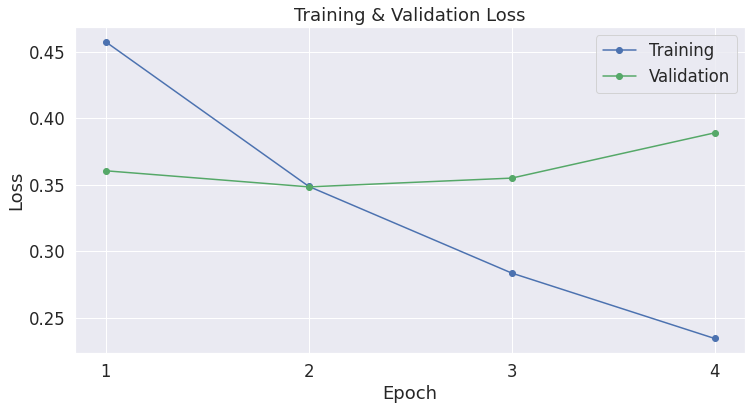

In [53]:
show_status(df_stats)

## 6.3 Evaluate on Test Set

In [54]:
prediction_dataloader = load_test_data(test_file)

Number of test sentences: 359



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [55]:
evaluate_test(prediction_dataloader)

Predicting labels for 384 test sentences...
Accuracy: 83.01%


## 6.4 Evaluate on Spanish Test Set

In [56]:
prediction_dataloader = load_test_data(spanish_test)

Number of test sentences: 359



/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [57]:
evaluate_test(prediction_dataloader)

Predicting labels for 384 test sentences...
Accuracy: 71.87%


# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Do it yourself

Modify the above tutorial to train a Twitter sentiment classification model (you can keep all the hyperparameters as before for this homework, with epochs=4). In reality, fine-tuning the hyperparameters for your data and task (e.g., using validation step to pick the best number of epochs) might improve performance.

1. (10 pts) Fine-tune English BERT with **all** of your examples in sentiment-train.csv and report the accuracy on sentiment-test.csv.
> 86.07%
2. (5 pts) Report the accuracy of this fine-tuned English BERT on spanish-sentiment-test.csv (this is zero-shot accuracy of the model trained on the English data and test on the Spanish data).
> 58.77%
3. (10 pts) Modify the code to use multilingual (XLM-Roberta) model (xlm-roberta-base), keeping the same hyperparameters as before. Fine-tune the multilingual model with **all** of your examples in sentiment-train.csv and report the accuracy on sentiment-test.csv.
> 83.01%
4. (5 pts) Report the accuracy of the multilingual model on spanish-sentiment-test.csv (this is zero-shot accuracy of the model trained on the English data and test on the Spanish data). Does the zero-shot performance using multilingual model improve over the English only BERT model?
> 71.87% <br>
Using multilingual model improve the zero-shot performance